## Predicting/Forecasting WTI Oil Price for next week using Vector Autoregression

In [1]:
#libraries and dataset
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# Creating static function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df = pd.read_csv("New-Var.csv")
df = df.dropna()
df.head(5)
df = df.set_index('Date')
df

,Utilization of Refinery in %,Production,Demand,Contract 1 FP,Global Sale (in millions),Last Day's Price,Price
Date,,,,,,,
2016-12-27,91.25,4514.068000,4349.654000,53.900,1.000438,53.460001,53.900002
2016-12-28,91.50,4511.956000,4364.348000,54.060,1.095955,53.900002,54.060001
2016-12-29,91.75,4509.844000,4379.042000,53.770,1.191472,54.060001,53.770000
2016-12-30,92.00,4507.732000,4393.736000,53.720,1.286989,53.770000,53.720001
2017-01-01,92.32,4505.620000,4408.430000,53.025,1.382506,53.745001,53.025002
...,...,...,...,...,...,...,...
2021-12-17,88.80,4615.823123,4439.108735,66.180,5.600000,72.379997,70.860001
2021-12-20,88.80,4616.459842,4439.844051,66.180,5.600000,70.860001,68.230003
2021-12-21,88.80,4617.096561,4440.579368,66.180,5.600000,68.230003,71.120003


In [3]:
#Testing Causation using Granger’s Causality Test
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

C:\Users\prathikm\miniconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\prathikm\miniconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\prathikm\miniconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,Utilization of Refinery in %_x,Production_x,Demand_x,Contract 1 FP_x,Global Sale (in millions)_x,Last Day's Price_x,Price_x
Utilization of Refinery in %_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0076,0.0000
Production_y,0.0003,1.0000,0.3297,0.0000,0.0000,0.0223,0.0000
Demand_y,0.0010,0.0000,1.0000,0.0000,0.0000,0.0611,0.0000
Contract 1 FP_y,0.8569,0.0857,0.1843,1.0000,0.3458,0.0270,0.0839
Global Sale (in millions)_y,0.1989,0.0003,0.0000,0.0000,1.0000,0.0014,0.0000
Last Day's Price_y,0.9145,0.0746,0.1680,0.0000,0.2445,1.0000,0.0000
Price_y,0.8893,0.0685,0.1559,0.2805,0.2368,0.0339,1.0000


In [4]:
# in the above production of oil, and last day's price has higher impact on oil price, since it has <0.05 value. 
# Next in importance is Demand, contract, EV Sales and URin% in order

In [5]:
#Cointegration Test

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Utilization of Refinery in % ::  333.58    > 111.7797  =>   True
Production ::  88.67     > 83.9383   =>   True
Demand ::  55.31     > 60.0627   =>   False
Contract 1 FP ::  31.36     > 40.1749   =>   False
Global Sale (in millions) ::  14.94     > 24.2761   =>   False
Last Day's Price ::  5.25      > 12.3212   =>   False
Price  ::  0.12      > 4.1296    =>   False


In [6]:
# Train Test Split - 80% 20%
nobs = 8
df_train, df_test = df[0:-nobs], df[-nobs:]
b2_train = df_train.iloc[-8:,:]

In [7]:
# Stationarity Test: - ADF
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [8]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Utilization of Refinery in %" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8546
 No. Lags Chosen       = 9
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0509. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Production" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.7139
 No. Lags Chosen       = 14
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.8431. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Demand" 
    -----------------------------------------------
 

In [9]:
# Since all are non-stationary: Difference and check them
# 1st difference
df_differenced = df_train.diff().dropna()

In [10]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Utilization of Refinery in %" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.4464
 No. Lags Chosen       = 8
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Production" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2953
 No. Lags Chosen       = 12
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [11]:
#Select the Order (P) of VAR model - Method 1
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\prathikm\miniconda3\envs\ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Lag Order = 1
AIC :  -20.506519776172503
BIC :  -20.279575491094278
FPE :  1.2420301110887399e-09
HQIC:  -20.42127094871562 

Lag Order = 2
AIC :  -20.89194947764258
BIC :  -20.466158800644937
FPE :  8.447826253152088e-10
HQIC:  -20.73200020808592 

Lag Order = 3
AIC :  -21.191946969369617
BIC :  -20.56705721795829
FPE :  6.258423638262059e-10
HQIC:  -20.95719649571489 

Lag Order = 4
AIC :  -22.60933383659455
BIC :  -21.785091802178457
FPE :  1.5167548266536837e-10
HQIC:  -22.29968118129962 

Lag Order = 5
AIC :  -27.531423936416473
BIC :  -26.507575882797642
FPE :  1.1048444269016393e-12
HQIC:  -27.146767905766726 

Lag Order = 6
AIC :  -27.527182428944315
BIC :  -26.303474090802304
FPE :  1.1096249828162016e-12
HQIC:  -27.067421612421686 

Lag Order = 7
AIC :  -27.507614786929544
BIC :  -26.08379136830029
FPE :  1.13167117102335e-12
HQIC:  -26.9726475565792 

Lag Order = 8
AIC :  -27.573719760962323
BIC :  -25.949525933711456
FPE :  1.0594298058634455e-12
HQIC:  -26.963444270757027 

In [12]:
x = model.select_order(maxlags=12) # Method 2
x.summary()

,AIC,BIC,FPE,HQIC
0,-13.85,-13.82,9.698e-07,-13.84
1,-27.08,-26.85,1.737e-12,-26.99
2,-27.36,-26.93*,1.307e-12,-27.20*
3,-27.42,-26.80,1.230e-12,-27.19
4,-27.44,-26.61,1.209e-12,-27.13
5,-27.49,-26.47,1.146e-12,-27.11
6,-27.50,-26.27,1.145e-12,-27.03
7,-27.48,-26.05,1.163e-12,-26.94
8,-27.55*,-25.92,1.083e-12*,-26.94
9,-27.54,-25.71,1.098e-12,-26.85


In [13]:
# from above we select lag 2

In [14]:
#Train the VAR Model of Selected Order(p)
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jan, 2022
Time:                     07:27:24
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.4662
Nobs:                     1269.00    HQIC:                  -20.7320
Log likelihood:           756.511    FPE:                8.44783e-10
AIC:                     -20.8919    Det(Omega_mle):     7.78074e-10
--------------------------------------------------------------------
Results for equation Utilization of Refinery in %
                                     coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------
const                                  -0.020528         0.011856           -1.731           0.083
L1.Utilization of Refinery in %         0.879185         0.03627

In [15]:
#Check for Serial Correlation of Residuals (Errors)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

Utilization of Refinery in % : 2.02
Production : 2.0
Demand : 2.01
Contract 1 FP : 2.0
Global Sale (in millions) : 2.0
Last Day's Price : 2.29
Price : 2.0


In [16]:
# Forecast VAR model using statsmodels
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

2


In [17]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 0.        ,  0.63671937,  0.73531621,  0.        ,  0.        ,
        -1.41999817,  0.72999573],
       [ 0.        ,  0.63671937,  0.73531621,  0.        ,  0.        ,
         0.72999573, -0.37999725]])

In [18]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Utilization of Refinery in %_2d,Production_2d,Demand_2d,Contract 1 FP_2d,Global Sale (in millions)_2d,Last Day's Price_2d,Price_2d
Date,,,,,,,
2021-12-14,0.020917,0.975338,1.099590,0.070694,0.004829,-0.353640,0.178992
2021-12-15,0.020591,0.786441,0.869391,-0.078418,0.001986,0.172934,-0.059487
2021-12-16,0.012942,0.901522,0.990880,0.028774,0.003634,-0.060215,0.019640
2021-12-17,0.014106,0.851370,0.927196,-0.009089,0.002883,0.021470,0.007563
2021-12-20,0.012126,0.865144,0.938265,-0.005246,0.003083,0.006441,0.004828
2021-12-21,0.011110,0.860137,0.929571,-0.001806,0.003019,0.005015,0.006367
2021-12-22,0.010369,0.858667,0.925849,-0.003667,0.003015,0.006148,0.006849
2021-12-23,0.009661,0.856880,0.922414,-0.003444,0.003010,0.006711,0.006135


In [19]:
# Invert the transformation to get the real forecast
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [20]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Utilization of Refinery in %_forecast', 'Production_forecast', 'Demand_forecast', 'Contract 1 FP_forecast',
                   'Global Sale (in millions)_forecast', 'Last Day\'s Price_forecast', 'Price_forecast']]

,Utilization of Refinery in %_forecast,Production_forecast,Demand_forecast,Contract 1 FP_forecast,Global Sale (in millions)_forecast,Last Day's Price_forecast,Price_forecast
Date,,,,,,,
2021-12-14,88.820917,4614.888303,4438.002376,66.250694,5.604829,72.046354,71.088996
2021-12-15,88.862425,4617.286801,4440.706674,66.242971,5.611644,72.595644,70.828503
2021-12-16,88.916875,4620.586822,4444.401850,66.264021,5.622093,73.084720,70.587650
2021-12-17,88.985430,4624.738212,4449.024224,66.275982,5.635424,73.595265,70.354360
2021-12-20,89.066112,4629.754747,4454.584862,66.282697,5.651838,74.112251,70.125898
2021-12-21,89.157904,4635.631420,4461.075072,66.287607,5.671272,74.634252,69.903803
2021-12-22,89.260065,4642.366758,4468.491130,66.288849,5.693721,75.162401,69.688556
2021-12-23,89.371886,4649.958978,4476.829602,66.286647,5.719179,75.697261,69.479444


In [32]:
#Test MAPE
a1_test = df_test['Price'].values
a2_results = df_results['Price_forecast'].values

mean_absolute_percentage_error(a1_test, a2_results)

2.288466192480982

In [35]:
#Train MAPE
b1_results = df_results['Price_forecast'].values
b3_train = b2_train['Price'].values

mean_absolute_percentage_error(b1_results, b3_train)

3.3734844371871167

In [23]:
# Plot the actual vs predicted values

In [24]:
test_price = df_test['Price']
test_price = pd.DataFrame(test_price)
test_price

,Price
Date,
2021-12-14,70.730003
2021-12-15,70.870003
2021-12-16,72.379997
2021-12-17,70.860001
2021-12-20,68.230003
2021-12-21,71.120003
2021-12-22,72.760002
2021-12-23,73.790001


In [25]:
forecast_price = df_results['Price_forecast']
forecast_price = pd.DataFrame(forecast_price)
forecast_price

,Price_forecast
Date,
2021-12-14,71.088996
2021-12-15,70.828503
2021-12-16,70.587650
2021-12-17,70.354360
2021-12-20,70.125898
2021-12-21,69.903803
2021-12-22,69.688556
2021-12-23,69.479444


In [26]:
data_VAR_P = pd.concat([test_price, forecast_price],axis=1,join='outer')
data_VAR_P = data_VAR_P.reset_index()
data_VAR_P

,Date,Price,Price_forecast
0,2021-12-14,70.730003,71.088996
1,2021-12-15,70.870003,70.828503
2,2021-12-16,72.379997,70.587650
3,2021-12-17,70.860001,70.354360
4,2021-12-20,68.230003,70.125898
5,2021-12-21,71.120003,69.903803
6,2021-12-22,72.760002,69.688556
7,2021-12-23,73.790001,69.479444


In [27]:
df_train[['Price']]

,Price
Date,
2016-12-27,53.900002
2016-12-28,54.060001
2016-12-29,53.770000
2016-12-30,53.720001
2017-01-01,53.025002
...,...
2021-12-07,72.050003
2021-12-08,72.360001
2021-12-09,70.940002


In [28]:
df_train_last_plot = df_train.tail(64)
df_train_last_plot

,Utilization of Refinery in %,Production,Demand,Contract 1 FP,Global Sale (in millions),Last Day's Price,Price
Date,,,,,,,
2021-09-15,85.34,4573.162925,4389.842549,72.61,5.6,70.459999,72.610001
2021-09-16,86.42,4573.799644,4390.577866,72.61,5.6,72.610001,72.610001
2021-09-17,87.50,4574.436364,4391.313182,71.97,5.6,72.610001,71.970001
2021-09-20,87.62,4575.073083,4392.048498,70.29,5.6,71.970001,70.290001
2021-09-21,87.74,4575.709802,4392.783814,70.56,5.6,70.290001,70.559998
...,...,...,...,...,...,...,...
2021-12-07,88.80,4610.729368,4433.226206,66.18,5.6,69.489998,72.050003
2021-12-08,88.80,4611.366087,4433.961522,66.18,5.6,72.050003,72.360001
2021-12-09,88.80,4612.002806,4434.696838,66.18,5.6,72.360001,70.940002


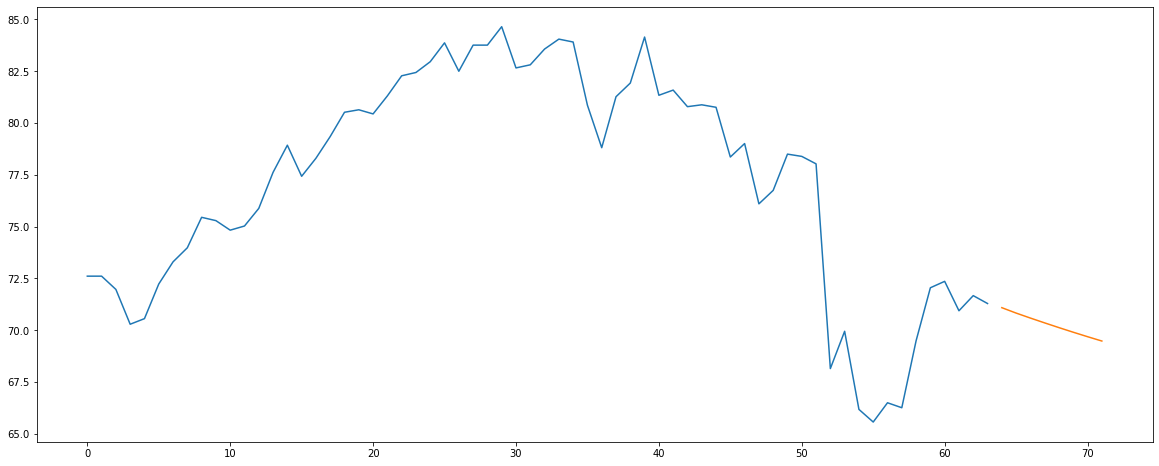

In [29]:
fig,ax = plt.subplots(figsize=(20,8))
plt.plot(np.arange(64), df_train_last_plot['Price'].values)
plt.plot(np.arange(64, 64+8), forecast_price.values)
plt.show()